In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

In [16]:
df = pd.read_csv('ecommerce_furniture_dataset_2024.csv')

In [17]:
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [18]:
df.isnull().sum()

productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
dtype: int64

In [19]:
df.shape

(2000, 5)

In [20]:
# clean price (remove $ and commas, convert to float)
if 'price' in df.columns:
    df['price'] = df['price'].astype(str).str.replace(r'[\$,]', '', regex=True)
    df['price'] = df['price'].str.strip()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# clean originalPrice and fill missing with price
if 'originalPrice' in df.columns:
    df['originalPrice'] = df['originalPrice'].astype(str).str.replace(r'[\$,]', '', regex=True)
    df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')
    df['originalPrice'] = df['originalPrice'].fillna(df['price'])

# create discount percentage safely
if 'price' in df.columns and 'originalPrice' in df.columns:
    df['discount_percentage'] = ((df['originalPrice'] - df['price']) / df['originalPrice']).fillna(0) * 100
else:
    df['discount_percentage'] = 0.0

# ensure sold is numeric non-negative integer (target)
if 'sold' in df.columns:
    df['sold'] = pd.to_numeric(df['sold'], errors='coerce').fillna(0)
    df['sold'] = df['sold'].apply(lambda x: max(0, int(np.floor(x)))).astype(int)
else:
    raise KeyError("Dataset must have a 'sold' column")

# simplify tagText and encode it
if 'tagText' in df.columns:
    df['tagText'] = df['tagText'].astype(str).str.strip()
    df.loc[df['tagText'].str.lower().str.contains('free', na=False), 'tagText'] = 'Free shipping'
    df.loc[~df['tagText'].isin(['Free shipping']), 'tagText'] = 'others'
    le_tag = LabelEncoder()
    df['tag_label'] = le_tag.fit_transform(df['tagText'])

# make sure productTitle is string for TF-IDF later
if 'productTitle' in df.columns:
    df['productTitle'] = df['productTitle'].astype(str).fillna('')

# remove rows where both price and sold are missing
before = len(df)
df.dropna(subset=['price', 'sold'], how='all', inplace=True)
after = len(df)

print(f"Data cleaned directly. {before - after} rows dropped.")
print("Current shape:", df.shape)
df.head(6)


Data cleaned directly. 0 rows dropped.
Current shape: (2000, 7)


,productTitle,originalPrice,price,sold,tagText,discount_percentage,tag_label
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,46.79,600,Free shipping,0.000000,0
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,169.72,0,Free shipping,0.000000,0
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping,49.668367,0
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,111.99,0,Free shipping,0.000000,0
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,Free shipping,56.226956,0
5,"3 Pieces Patio Furniture Set, Outdoor Swivel G...",1294.04,123.40,53,Free shipping,90.463973,0


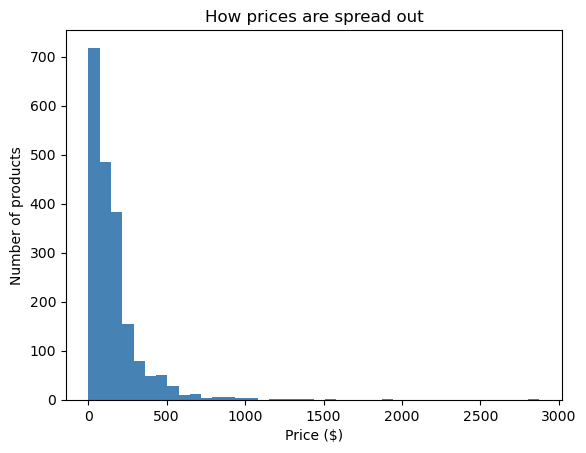

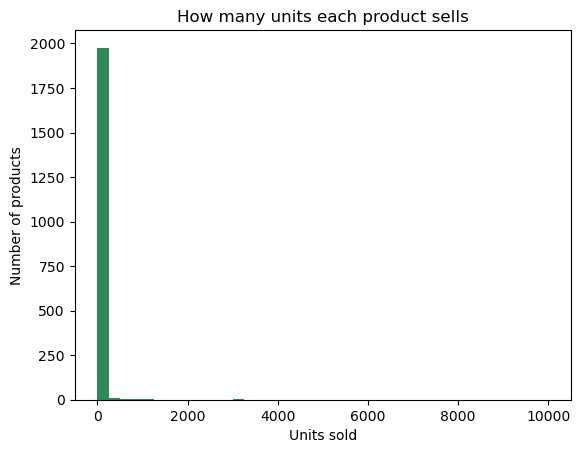

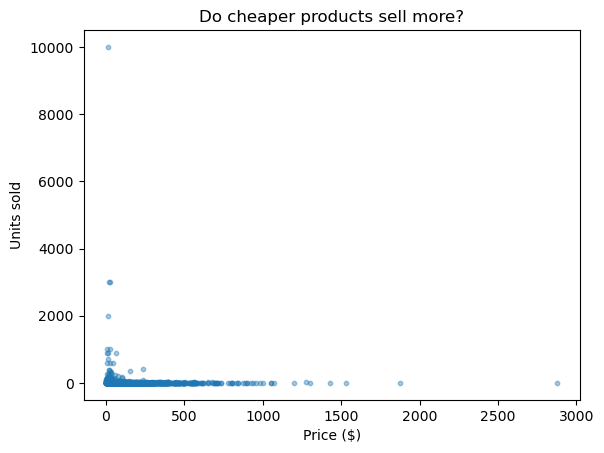

Top 10 most common words in product titles:
         word  importance
18      table  308.259415
17    storage  254.603463
7   furniture  232.801643
3       chair  216.298759
14        set  207.468234
1     bedroom  198.547376
13       room  188.435820
16       sofa  182.627827
10     modern  168.371470
9      living  164.484325


In [21]:
# 6) Quick look at our data after cleaning

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Price distribution ---
plt.hist(df['price'].dropna(), bins=40, color='steelblue')
plt.title("How prices are spread out")
plt.xlabel("Price ($)")
plt.ylabel("Number of products")
plt.show()

# --- Sold distribution ---
plt.hist(df['sold'].dropna(), bins=40, color='seagreen')
plt.title("How many units each product sells")
plt.xlabel("Units sold")
plt.ylabel("Number of products")
plt.show()

# --- Relationship between price and sold ---
plt.scatter(df['price'], df['sold'], alpha=0.4, s=10)
plt.title("Do cheaper products sell more?")
plt.xlabel("Price ($)")
plt.ylabel("Units sold")
plt.show()

# --- Look at the most common words in product titles (optional) ---
if 'productTitle' in df.columns:
    vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
    words = vectorizer.fit_transform(df['productTitle'])
    word_sums = words.sum(axis=0).A1
    top_words = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'importance': word_sums})
    top_words = top_words.sort_values(by='importance', ascending=False)
    print("Top 10 most common words in product titles:")
    print(top_words.head(10))


In [22]:
# 7) choose features and build a clean pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Use df directly since we cleaned it in place
text_col = 'productTitle' if 'productTitle' in df.columns else None
numeric_cols = [c for c in ['price', 'discount_percentage', 'tag_label'] if c in df.columns]

print("text column:", text_col)
print("numeric columns:", numeric_cols)

# Build transformers
transformers = []
if text_col:
    transformers.append(('text', TfidfVectorizer(max_features=300, stop_words='english'), text_col))
if numeric_cols:
    transformers.append(('num', StandardScaler(), numeric_cols))

col_trans = ColumnTransformer(transformers=transformers, remainder='drop')

# Create simple pipelines for two models
pipe_lr = Pipeline([
    ('pre', col_trans),
    ('model', LinearRegression())
])

pipe_rf = Pipeline([
    ('pre', col_trans),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


text column: productTitle
numeric columns: ['price', 'discount_percentage', 'tag_label']


In [23]:
# This cell will also recreate simple pipelines if they are missing.

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Make sure we use the cleaned DataFrame 'df'
X = df.drop(columns=['sold'])
y = df['sold']

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# If pipelines don't exist (e.g., after a kernel restart), make simple ones here
try:
    pipe_lr
    pipe_rf
except NameError:
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor

    text_col = 'productTitle' if 'productTitle' in df.columns else None
    numeric_cols = [c for c in ['price', 'discount_percentage', 'tag_label'] if c in df.columns]

    transformers = []
    if text_col:
        transformers.append(('text', TfidfVectorizer(max_features=300, stop_words='english'), text_col))
    if numeric_cols:
        transformers.append(('num', StandardScaler(), numeric_cols))

    col_trans = ColumnTransformer(transformers=transformers, remainder='drop')
    pipe_lr = Pipeline([('pre', col_trans), ('model', LinearRegression())])
    pipe_rf = Pipeline([('pre', col_trans), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
    print("Pipelines recreated: LinearRegression and RandomForest")

# Fit Linear Regression (fast baseline)
print("\nTraining Linear Regression (baseline)...")
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)
print(f"Linear Regression -> MSE: {mse_lr:.3f}, R2: {r2_lr:.3f}")

# Fit Random Forest (stronger baseline)
print("\nTraining Random Forest (this takes longer)...")
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)
print(f"Random Forest -> MSE: {mse_rf:.3f}, R2: {r2_rf:.3f}")


Train size: (1600, 6) Test size: (400, 6)

Training Linear Regression (baseline)...
Linear Regression -> MSE: 26195.916, R2: -3.777

Training Random Forest (this takes longer)...
Random Forest -> MSE: 11776.032, R2: -1.148


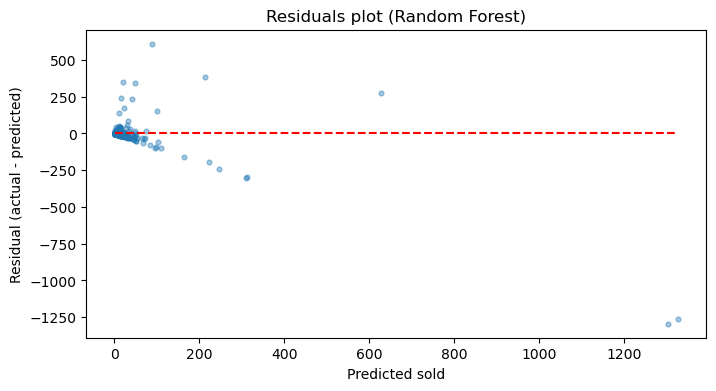

Numeric feature importances (approx):


discount_percentage    0.515265
price                  0.483641
tag_label              0.001094
dtype: float64

In [24]:
# Check residuals for the Random Forest and show numeric importances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Residuals plot (Random Forest)
residuals = y_test - pred_rf
plt.figure(figsize=(8,4))
plt.scatter(pred_rf, residuals, alpha=0.4, s=12)
plt.hlines(0, xmin=np.min(pred_rf), xmax=np.max(pred_rf), colors='red', linestyles='dashed')
plt.xlabel('Predicted sold')
plt.ylabel('Residual (actual - predicted)')
plt.title('Residuals plot (Random Forest)')
plt.show()

# Numeric feature importance (train a small RF on numeric columns only)
numeric_cols = [c for c in ['price', 'discount_percentage', 'tag_label'] if c in df.columns]
if numeric_cols:
    from sklearn.ensemble import RandomForestRegressor
    rf_num = RandomForestRegressor(n_estimators=200, random_state=42)
    X_num = df[numeric_cols].fillna(0)
    rf_num.fit(X_num, df['sold'])
    importances = pd.Series(rf_num.feature_importances_, index=numeric_cols).sort_values(ascending=False)
    print("Numeric feature importances (approx):")
    display(importances)
else:
    print("No numeric columns found for importance check.")


In [25]:
# Step 10: Save the trained Random Forest pipeline and any encoders
import joblib
import os

OUTPUT_DIR = "/mnt/data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

model_path = os.path.join(OUTPUT_DIR, "furniture_pipeline_rf.joblib")
joblib.dump(pipe_rf, model_path)
print("Saved Random Forest pipeline to:", model_path)

# If a tag LabelEncoder exists, save it too
if 'le_tag' in globals():
    le_path = os.path.join(OUTPUT_DIR, "label_encoder_tag.joblib")
    joblib.dump(le_tag, le_path)
    print("Saved tag label encoder to:", le_path)
else:
    print("No tag label encoder found in memory to save.")

# Quick sanity check: load back and run a tiny prediction
loaded = joblib.load(model_path)
sample = X_test.head(3)
print("\nSample predictions from loaded pipeline:")
print(loaded.predict(sample))


Saved Random Forest pipeline to: /mnt/data\furniture_pipeline_rf.joblib
Saved tag label encoder to: /mnt/data\label_encoder_tag.joblib

Sample predictions from loaded pipeline:
[ 1.23        4.66666667 46.4       ]


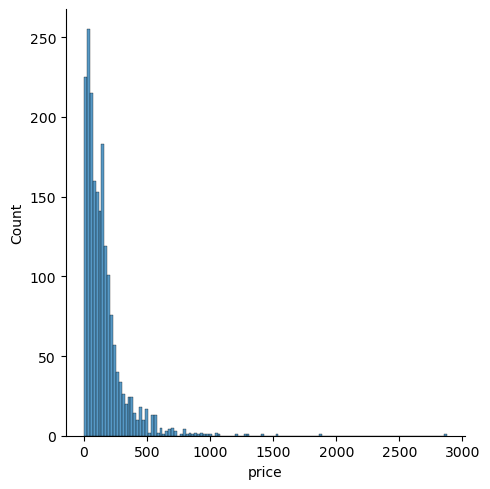

In [26]:
sns.displot(df['price'])


<Axes: xlabel='price', ylabel='sold'>

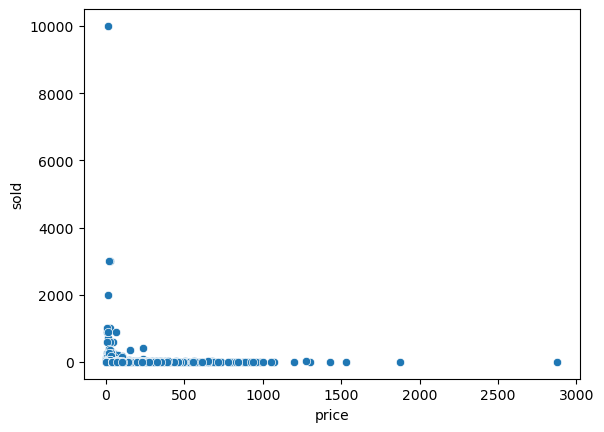

In [27]:

sns.scatterplot(x='price', y='sold', data=df)

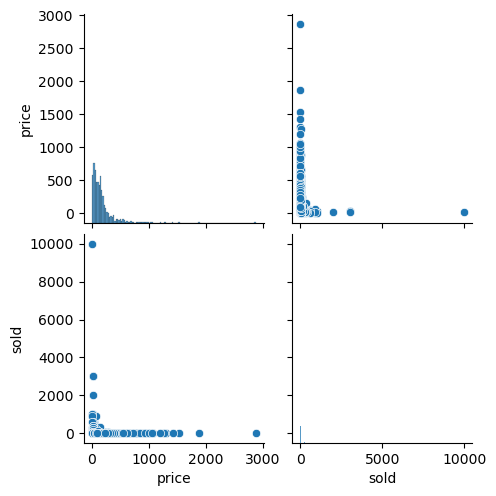

In [28]:
filtered_df = df[df['tagText'] == 'Free shipping']
# Create a pairplot including the 'sold' column and other relevant columns
sns.pairplot(filtered_df[['price', 'sold']])


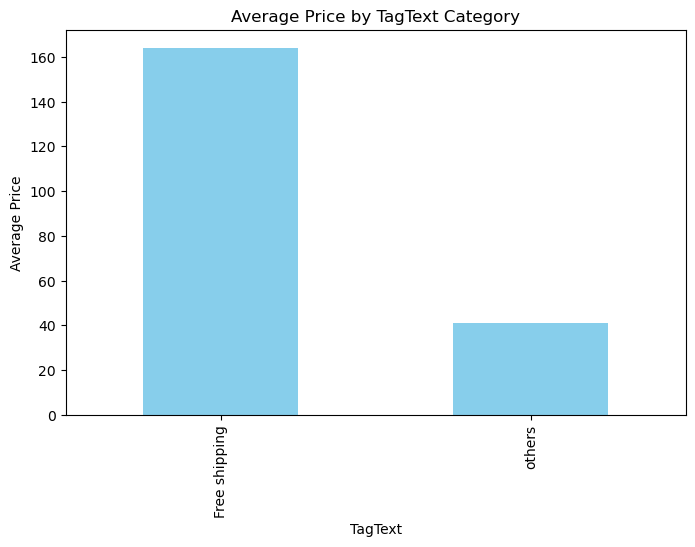

C:\Users\HP\AppData\Local\Temp\ipykernel_7668\1314852936.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


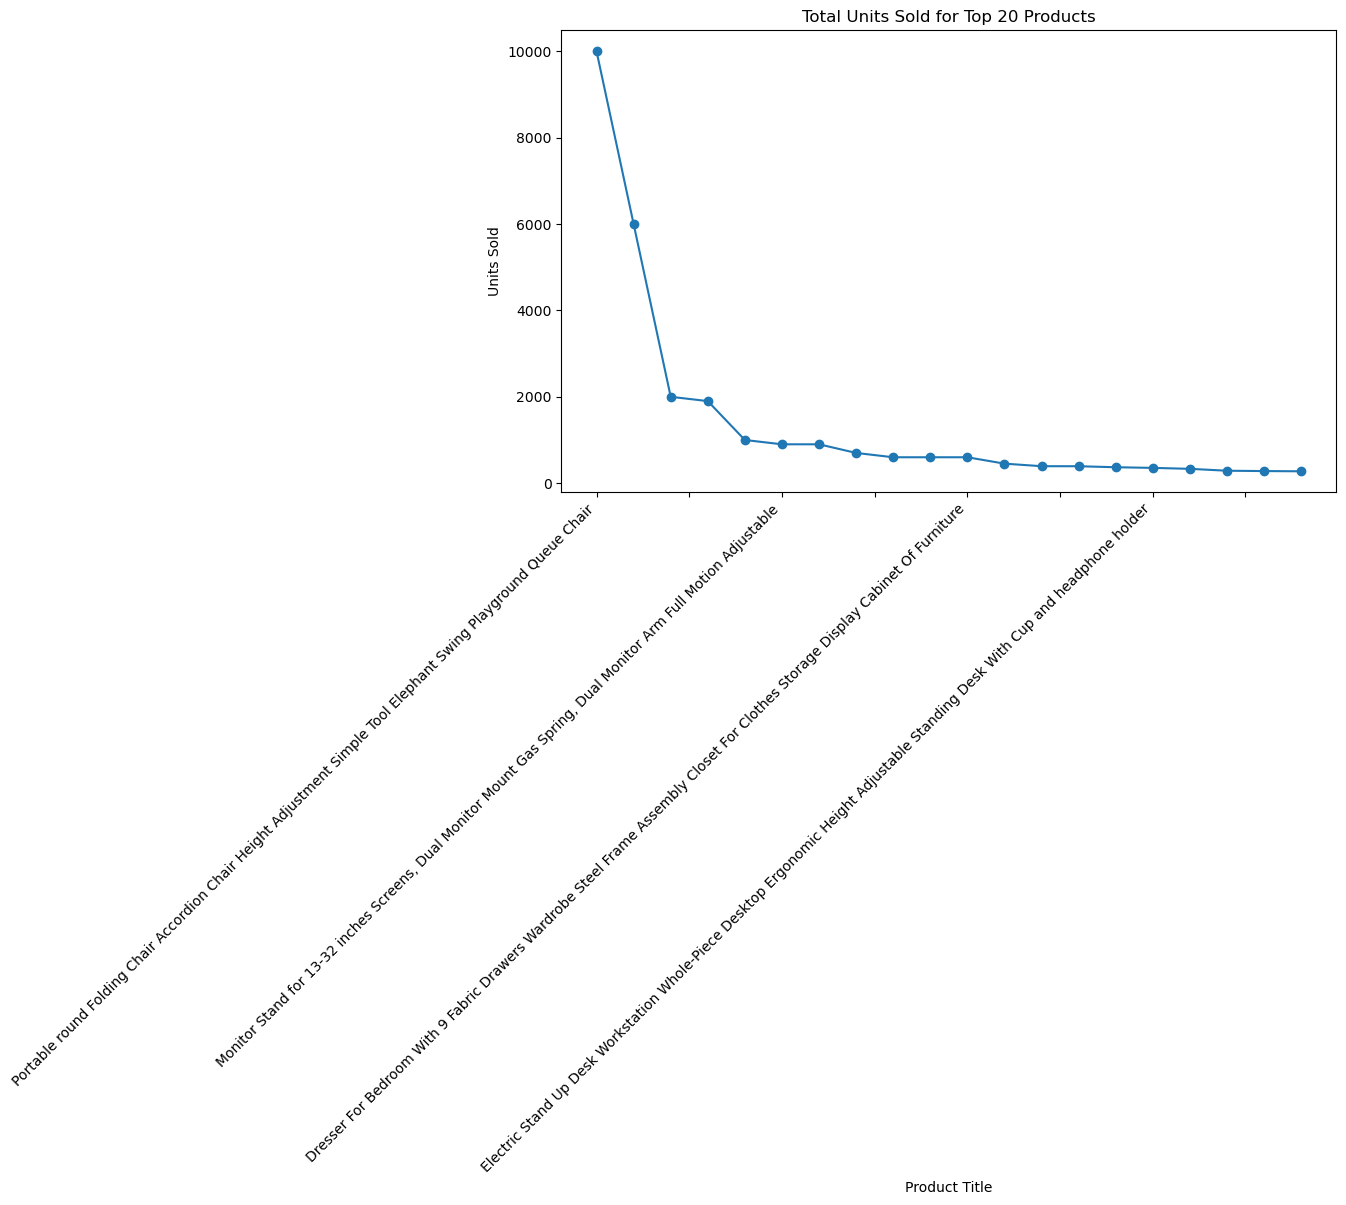

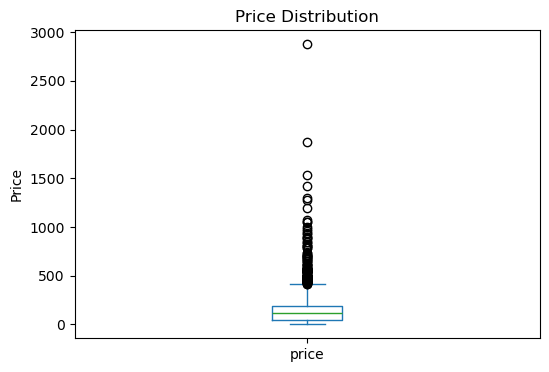

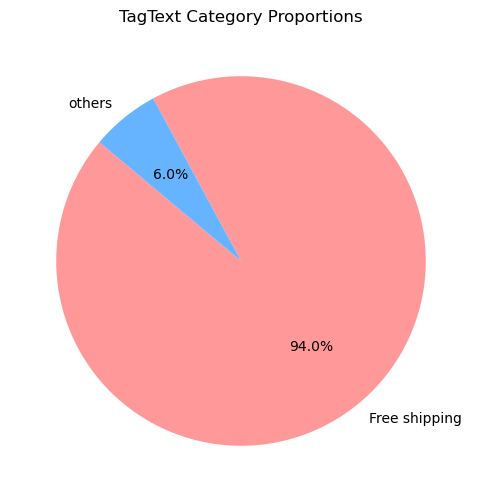

In [30]:
def visualize_furniture_data_simple(df):

    plt.figure(figsize=(8, 5))
    # Bar plot: avg price by tagText
    avg_price_by_tag = df.groupby('tagText')['price'].mean()
    avg_price_by_tag.plot(kind='bar', color='skyblue')
    plt.title('Average Price by TagText Category')
    plt.xlabel('TagText')
    plt.ylabel('Average Price')
    plt.show()
    
    # Line plot: total units sold by productTitle (limited to top 20 for clarity)
    if 'productTitle' in df.columns and 'sold' in df.columns:
        top_products = df.groupby('productTitle')['sold'].sum().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10, 6))
        top_products.plot(kind='line', marker='o')
        plt.title('Total Units Sold for Top 20 Products')
        plt.xlabel('Product Title')
        plt.ylabel('Units Sold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Box plot: price distribution
    plt.figure(figsize=(6, 4))
    df['price'].plot(kind='box')
    plt.title('Price Distribution')
    plt.ylabel('Price')
    plt.show()
    
    # Pie chart: tagText category proportions
    plt.figure(figsize=(6, 6))
    df['tagText'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title('TagText Category Proportions')
    plt.ylabel('')
    plt.show()


visualize_furniture_data_simple(df)